In [24]:
import sys
sys.path.append('..')
import os
import umap.umap_ as umap
import matplotlib.pyplot as plt
from amino_acid_encoding import SequenceEncoder, read_encoding_file

parent_dir = os.path.abspath('..')                # path to parent directory
data_dir = parent_dir + '/data/spike_proteins/'   # path to datasets

In [53]:
def get_encoded_sequences(infile, encoding_type):
    encoder = SequenceEncoder(encoding_type = encoding_type)
    print(encoder.encoding_type)
    frequencies, encoded_sequences = encoder.encode_from_fasta_file(infile, f'1_in_500_encoded_{encoding_type}.txt')
    return frequencies, encoded_sequences

In [54]:
def UMAP_embed(encoded_sequences, metric, seed):
    reducer = umap.UMAP(metric=metric, random_state=seed)
    sequence_embeddings = reducer.fit_transform(encoded_sequences)
    return sequence_embeddings

In [55]:
def plot_2D_map(embeddings, frequencies, labels = None, markerSize = 1):
    scaled_frequencies = [frequency * markerSize for frequency in frequencies]
    plt.scatter(sequence_embedding[:,0],
                 sequence_embedding[:,1],
                s=scaled_frequencies, alpha=0.25)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gcf().set_size_inches(12, 12)
    plt.title('UMAP projection of SARS-COV19 spike proteins', fontsize=20)
    if labels is not None:
        plt.gca().text(0.95, 0.95, '\n'.join(labels), horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

In [56]:
def generate_2D_map(aligned_fasta_file, encoding_type='PAM250', UMAP_metric='cosine', seed=42, markerSize=1):
    frequencies, encoded_sequences = get_encoded_sequences(infile=aligned_fasta_file, encoding_type=encoding_type)
    print(encoded_sequences)
    sequence_embeddings = UMAP_embed(encoded_sequences, metric = UMAP_metric, seed=seed)
    print(sequence_embeddings)
    plot_2D_map(sequence_embeddings, frequencies, markerSize=markerSize, labels=[encoding_type, UMAP_metric])

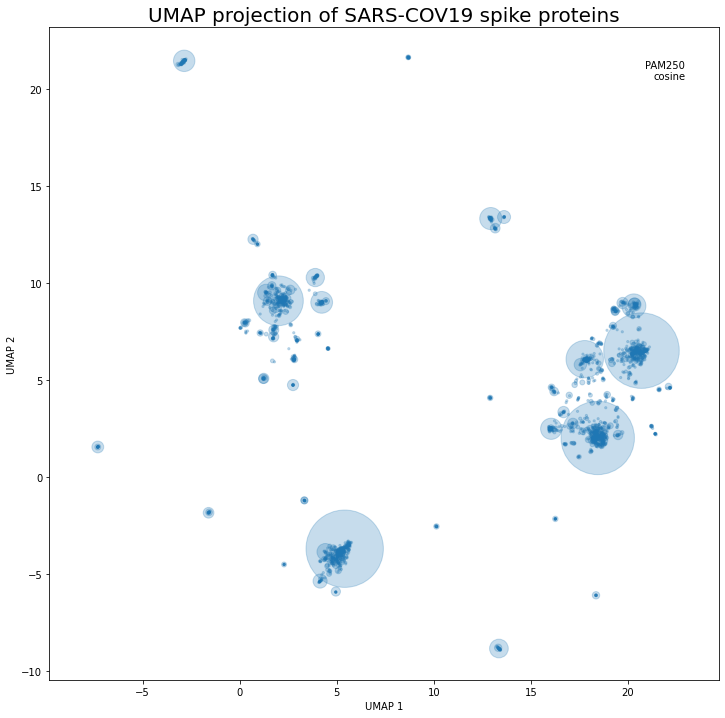

In [47]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='PAM250', UMAP_metric='cosine', markerSize=5)

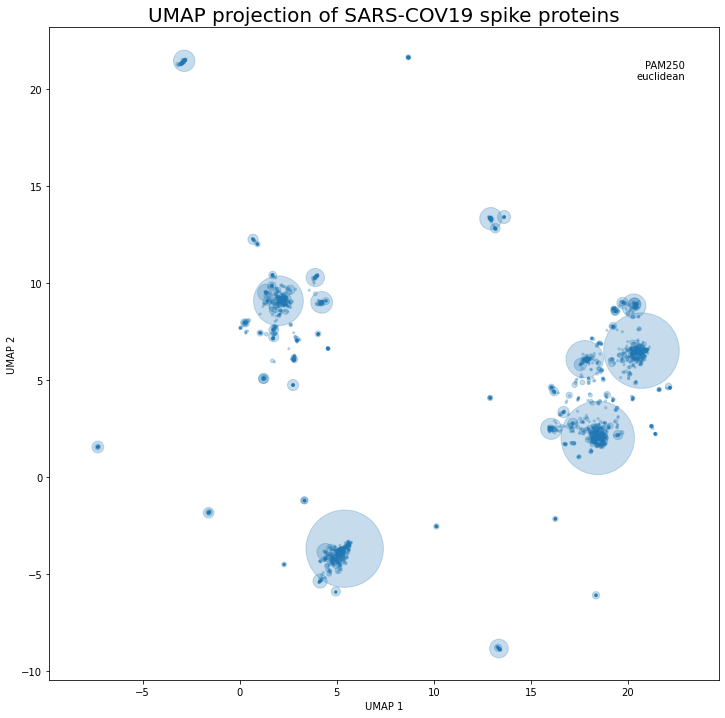

In [48]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='PAM250', UMAP_metric='euclidean', markerSize=5)

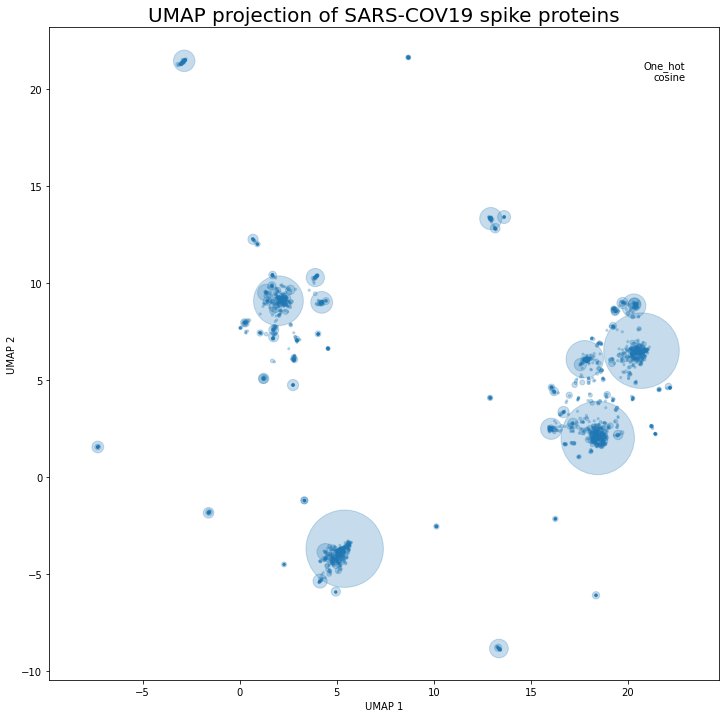

In [49]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='One_hot', UMAP_metric='cosine', markerSize=5)

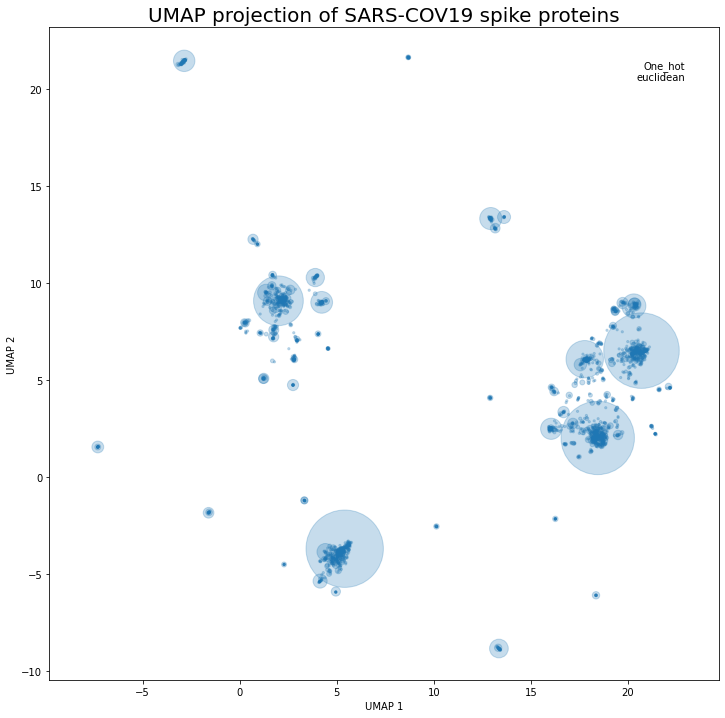

In [50]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='One_hot', UMAP_metric='euclidean', markerSize=5)

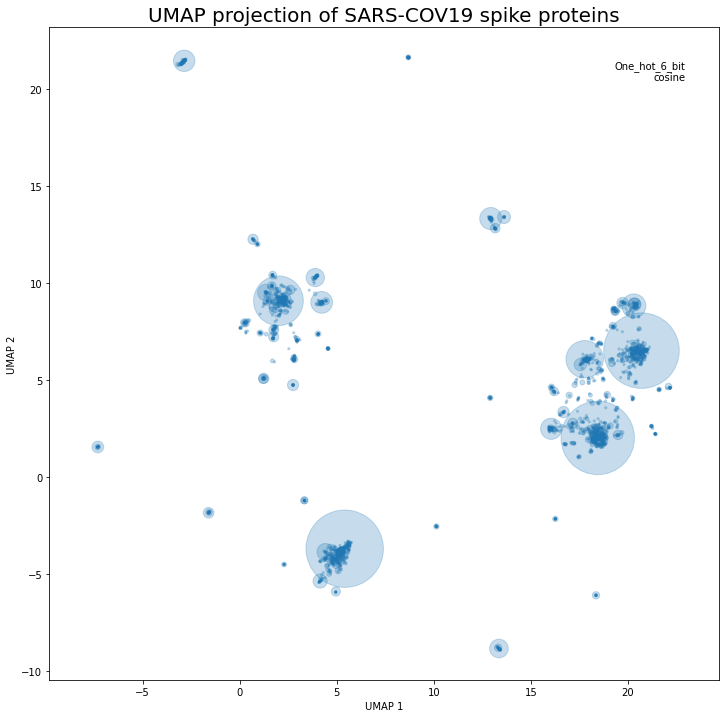

In [51]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='One_hot_6_bit', UMAP_metric='cosine', markerSize=5)

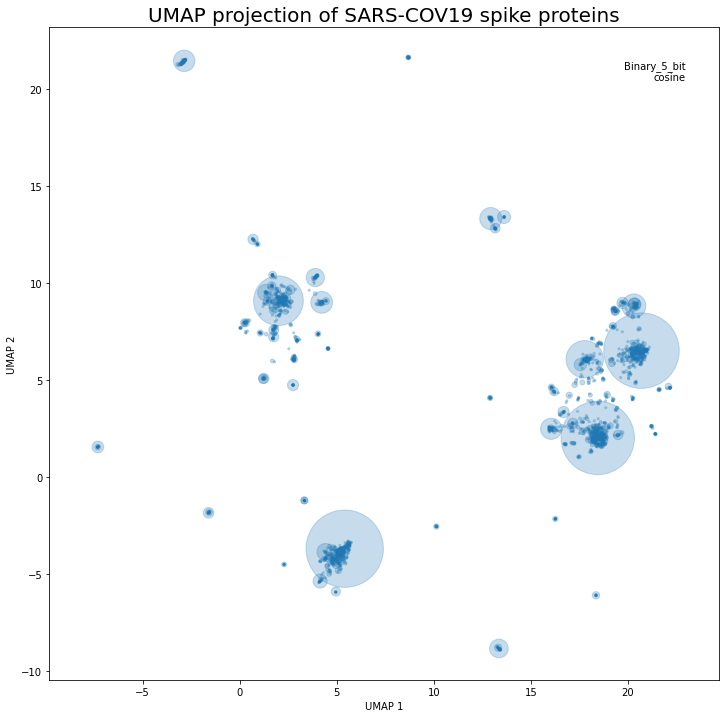

In [52]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='Binary_5_bit', UMAP_metric='cosine', markerSize=5)

PAM250
[[-1.  0. -2. ... -5. -3.  0.]
 [-1.  0. -2. ... -5. -3.  0.]
 [-1.  0. -2. ... -5. -3.  0.]
 ...
 [-1.  0. -2. ... -5. -3.  0.]
 [-1.  0. -2. ... -5. -3.  0.]
 [-1.  0. -2. ... -5. -3.  0.]]
[[ 1.2299408  5.094055 ]
 [ 1.2174623  5.071203 ]
 [ 1.2390515  5.1201134]
 ...
 [ 1.6749383 10.412426 ]
 [ 1.6605009 10.392107 ]
 [ 1.6829804 10.412285 ]]


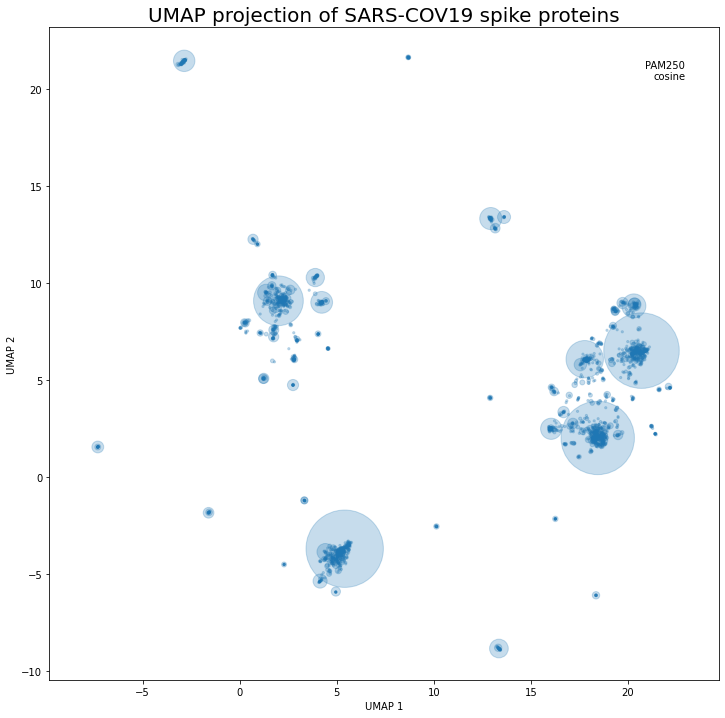

In [58]:
generate_2D_map('1_in_500_cleaned_aligned.afa', encoding_type='PAM250', UMAP_metric='cosine', markerSize=5)